# 3.0 Make predictions

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score
from sklearn.externals import joblib
import xgboost as xgb
import os
%matplotlib inline

def sound():
    os.system('afplay /System/Library/Sounds/Sosumi.aiff')

path = '/'.join(os.getcwd().split('/')[:-2])
print(path)

/Volumes/Dropbox/largetransfer/luc/carter


In [3]:
# load the models

rfc = joblib.load(path+'/data/models/rfc2.pkl') 
lr = joblib.load(path+'/data/models/lr2.pkl') 
gbm = xgb.Booster() #init model
gbm.load_model(path+'/data/models/gbm2.pkl')

In [4]:
# for the date range
rng = pd.date_range('10/1/2009', periods=23, freq='3MS')
all_preds = pd.DataFrame()
for date in rng:
    # read file for date
    df = pd.read_csv(path+'/data/model_data/tci_3_0_'+str(date.year)+'_'+str(date.month)+'.csv', index_col=0)
    features = list(df.columns)
    features.remove('vacant')
    # xgb matrix
    dmat = xgb.DMatrix(df[features])
    # make predictions
    pred_r = rfc.predict_proba(df[features])
    pred_g = gbm.predict(dmat)
    pred_l = lr.predict_proba(df[features])
    # put preds in matrix
    preds = pd.concat([pd.DataFrame(pred_r[:,1], index=df.index).rename(columns={0:'rf'}),\
           pd.DataFrame(pred_l[:,1], index=df.index).rename(columns={0:'lr'}),\
           pd.DataFrame(pred_g, index=df.index).rename(columns={0:'gbm'}),\
           df[['pv_count']]], axis=1).reset_index()
    preds['date'] = date
    all_preds = pd.concat([all_preds, preds], axis=0)
    # print preds
    print(date, sum(pd.Series(gbm.predict(dmat)).apply(lambda x: 0 if x < 0.3 else 1)), \
          sum(pd.Series(pred_r[:,1]).apply(lambda x: 0 if x < 0.4 else 1)),\
          sum(pd.Series(pred_l[:,1]).apply(lambda x: 0 if x < 0.5 else 1)))
    
# output to file
all_preds.to_csv(path+'/outputs/all_predictions.csv')

2009-10-01 00:00:00 6328 8385 19563
2010-01-01 00:00:00 6969 8541 17026
2010-04-01 00:00:00 7184 9152 20865
2010-07-01 00:00:00 7879 8464 16246
2010-10-01 00:00:00 6497 8744 14126
2011-01-01 00:00:00 6255 8904 14071
2011-04-01 00:00:00 6445 9812 14548
2011-07-01 00:00:00 6342 9495 12893
2011-10-01 00:00:00 6026 8837 11043
2012-01-01 00:00:00 6347 8711 10474
2012-04-01 00:00:00 7900 9132 11987
2012-07-01 00:00:00 7278 9794 10682
2012-10-01 00:00:00 7598 9432 9871
2013-01-01 00:00:00 8566 9727 9499
2013-04-01 00:00:00 9076 11533 12448
2013-07-01 00:00:00 9040 11593 12017
2013-10-01 00:00:00 8375 11014 11286
2014-01-01 00:00:00 8473 11038 10919
2014-04-01 00:00:00 8808 12012 11324
2014-07-01 00:00:00 8986 11979 10945
2014-10-01 00:00:00 8572 11556 10504
2015-01-01 00:00:00 9266 13028 11366
2015-04-01 00:00:00 8937 12738 10919


In [3]:
all_preds = pd.read_csv(path+'/outputs/all_predictions.csv', index_col=0, parse_dates=['date'])

In [4]:
# merge foreclosure status onto the predictions
fc_status = pd.read_csv(path+'/data/clean_data/parcel_status.csv')

In [5]:
fc_pivoted = fc_status.set_index(['parcel']).stack().reset_index().rename(columns={'level_1':'date',0:'fc_status'})
fc_pivoted['fc_status_mod'] = fc_pivoted['fc_status'] % 3
fc_pivoted = fc_pivoted.sort_values(by=['date','parcel'])
fc_pivoted = fc_pivoted.reset_index()
fc_pivoted = fc_pivoted.drop(fc_pivoted.columns[0],axis=1)

In [16]:
all_preds = all_preds.reset_index()
all_preds = all_preds.drop(all_preds.columns[0],axis=1)

In [18]:
all_preds[['fc_status','fc_status_mod']] = fc_pivoted[['fc_status','fc_status_mod']]

In [23]:
all_preds[['parcel','date','rf','lr','gbm','pv_count','fc_status','fc_status_mod']]\
    .to_csv(path+'/outputs/all_predictions_with_fc.csv')

## Importances

In [110]:
all_preds['gbm_vacant'] = all_preds.gbm>0.3
def count_vacant(x):
    period = 0
    periods = []
    for date in x.gbm_vacant:
        curr = date
        if curr:
            period += 1
        if not curr and period > 0:
            periods.append(period)
            period = 0
    if period > 0:
        periods.append(period)
    return periods
gbm_vacancy_periods = all_preds.groupby('parcel').apply(count_vacant)
gbm_vacancy_periods = [item for sublist in gbm_vacancy_periods.values for item in sublist]

In [111]:
sum(gbm_vacancy_periods)

177147

(array([ 20233.,   3325.,   2772.,   1684.,   1361.,   1121.,    840.,
           823.,    736.,    550.,    472.,    620.,    538.,    281.,
           294.,    287.,    195.,    226.,    240.,    307.,    990.]),
 array([  1.        ,   2.04761905,   3.0952381 ,   4.14285714,
          5.19047619,   6.23809524,   7.28571429,   8.33333333,
          9.38095238,  10.42857143,  11.47619048,  12.52380952,
         13.57142857,  14.61904762,  15.66666667,  16.71428571,
         17.76190476,  18.80952381,  19.85714286,  20.9047619 ,
         21.95238095,  23.        ]),
 <a list of 21 Patch objects>)

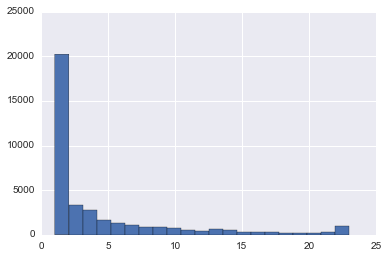

In [112]:
plt.hist(gbm_vacancy_periods,21)

In [113]:
all_preds['lr_vacant'] = all_preds.lr>0.6
def count_vacant(x):
    period = 0
    periods = []
    for date in x.lr_vacant:
        curr = date
        if curr:
            period += 1
        if not curr and period > 0:
            periods.append(period)
            period = 0
    if period > 0:
        periods.append(period)
    return periods
lr_vacancy_periods = all_preds.groupby('parcel').apply(count_vacant)
lr_vacancy_periods = [item for sublist in lr_vacancy_periods.values for item in sublist]

In [87]:
all_preds[all_preds.gbm>0.3].shape, all_preds[all_preds.lr>0.6].shape

((177147, 10), (203424, 10))

In [114]:
sum(lr_vacancy_periods),sum(gbm_vacancy_periods),sum(fc_vacancy_periods)

(203424, 177147, 19414)

In [148]:
pv,binEdges = np.histogram(pv_vacancy_periods,bins=22)
fc,binEdges = np.histogram(fc_vacancy_periods,bins=22)
gbm,binEdges = np.histogram(gbm_vacancy_periods,bins=22)
lr,binEdges = np.histogram(lr_vacancy_periods,bins=22)


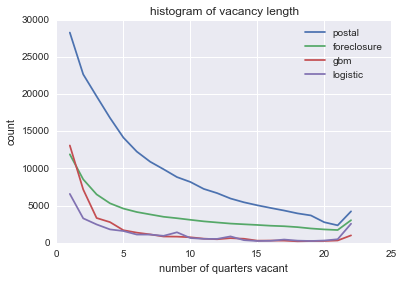

In [170]:
plt.plot(binEdges[0:-1],pv)
plt.plot(binEdges[0:-1],fc)
plt.plot(binEdges[0:-1],gbm)
plt.plot(binEdges[0:-1],lr)
plt.legend(['postal','foreclosure','gbm','logistic'])
plt.xlabel('number of quarters vacant')
plt.ylabel('count')
plt.title('histogram of vacancy length');
plt.savefig(path+'/outputs/histogram_vacancy_length.png')

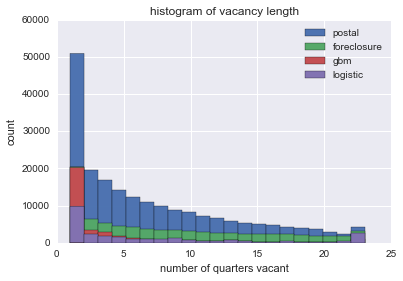

In [146]:

plt.hist(pv_vacancy_periods,21,alpha=0.99)
plt.hist(fc_vacancy_periods,21,alpha=0.99)
plt.hist(gbm_vacancy_periods,21,alpha=0.99)
# plt.subplot(2,2,1)
plt.hist(lr_vacancy_periods,21,alpha=0.99)
# plt.subplot(2,2,2)

# plt.subplot(2,2,3)

# plt.subplot(2,2,4)

plt.legend(['postal','foreclosure','gbm','logistic'])
plt.xlabel('number of quarters vacant')
plt.ylabel('count')
plt.title('histogram of vacancy length');

In [120]:
# all_preds['lr_vacant'] = all_preds.lr>0.6
def count_vacant(x):
    period = 0
    periods = []
    for date in x.pv_count:
        curr = date
        if curr>0:
            period += 1
        if curr==0 and period > 0:
            periods.append(period)
            period = 0
        if period > 0:
            periods.append(period)
    return periods
pv_vacancy_periods = all_preds.groupby('parcel').apply(count_vacant)
pv_vacancy_periods = [item for sublist in pv_vacancy_periods.values for item in sublist]

In [121]:
# all_preds['lr_vacant'] = all_preds.lr>0.6
def count_vacant(x):
    period = 0
    periods = []
    for date in x.fc_status_mod:
        curr = date
        if curr==2:
            period += 1
        if curr!=2 and period > 0:
            periods.append(period)
            period = 0
        if period > 0:
            periods.append(period)
    return periods
fc_vacancy_periods = all_preds.groupby('parcel').apply(count_vacant)
fc_vacancy_periods = [item for sublist in fc_vacancy_periods.values for item in sublist]

(array([ 2055.,  1204.,   656.,   336.,   200.,   130.,   127.,    99.,
          102.,    77.,    48.,    46.,    35.,    31.,    37.,    33.,
           43.,    39.,    34.,    19.,    46.]),
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.]),
 <a list of 21 Patch objects>)

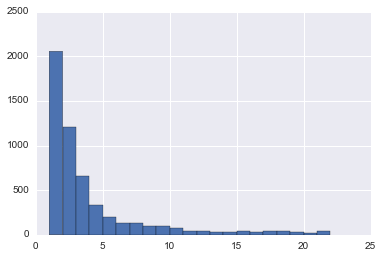

In [76]:
plt.hist(fc_vacancy_periods,21)

In [55]:
all_preds[all_preds.gbm>0.3]

parcel        rf        lr       gbm  pv_count       date  \
55       001-02-020  0.381252  0.009456  0.326994         0 2009-10-01   
114      001-04-016  0.378191  0.000293  0.432683         0 2009-10-01   
154      001-05-025  0.400284  0.000160  0.709211         0 2009-10-01   
209      001-07-020  0.332832  0.576201  0.400282         3 2009-10-01   
233      001-07-053  0.357039  0.476639  0.494334         3 2009-10-01   
241      001-07-063  0.306186  0.473463  0.394952         0 2009-10-01   
260      001-07-084  0.476084  0.388744  0.442198         0 2009-10-01   
296      001-08-059  0.387338  0.776960  0.510911         0 2009-10-01   
300      001-08-063  0.460488  0.694958  0.375172         0 2009-10-01   
305      001-08-068  0.536481  0.711909  0.328398         1 2009-10-01   
312      001-08-075  0.231740  0.508032  0.331988         0 2009-10-01   
352      001-08-122  0.296520  0.088120  0.329629         0 2009-10-01   
373      001-08-145  0.439808  0.614500  0.355313         0 2009-10-01   
421      001-09-050  0.325821  0.495464  0.301299         0 2009-10-01   
435      001-09-066  0.462666  0.441810  0.374315         0 2009-10-01   
495      001-10-052  0.557123  0.257463  0.317114         0 2009-10-01   
561      001-12-012  0.466850  0.234772  0.358738         0 2009-10-01   
562      001-12-013  0.317354  0.166067  0.374539         0 2009-10-01   
665      001-13-049  0.435768  0.320745  0.329416         0 2009-10-01   
668      001-13-052  0.355813  0.183295  0.329392         0 2009-10-01   
851      001-16-035  0.562997  0.694901  0.532804         3 2009-10-01   
890      001-16-074  0.425319  0.443136  0.425914         0 2009-10-01   
980      001-17-018  0.264833  0.225581  0.376424         2 2009-10-01   
1082     001-18-063  0.459037  0.130452  0.569362         0 2009-10-01   
1095     001-18-085  0.252190  0.271129  0.357906         0 2009-10-01   
1106     001-18-097  0.402487  0.472858  0.349879         0 2009-10-01   
1131     001-19-044  0.487309  0.306068  0.332994         0 2009-10-01   
1286     001-23-023  0.431688  0.427517  0.432611         0 2009-10-01   
1340     001-24-028  0.284319  0.458167  0.348701         2 2009-10-01   
1373     001-25-004  0.390647  0.573586  0.376516         3 2009-10-01   
...             ...       ...       ...       ...       ...        ...   
2601411  144-02-023  0.970998  0.862641  0.810073         0 2015-04-01   
2601415  144-02-027  0.898311  0.999250  0.705627        24 2015-04-01   
2601444  144-02-060  0.948750  0.999296  0.688854        28 2015-04-01   
2601451  144-02-067  0.376737  0.098603  0.333210         0 2015-04-01   
2601457  144-02-073  0.284910  0.345687  0.300498         0 2015-04-01   
2601469  144-02-085  0.944251  0.999950  0.820487        24 2015-04-01   
2601482  144-02-098  0.911612  0.858746  0.763350         3 2015-04-01   
2601517  144-03-021  0.516046  0.110951  0.320488         0 2015-04-01   
2601533  144-03-037  0.976544  0.999879  0.898655        28 2015-04-01   
2601538  144-04-004  0.809885  0.994990  0.794748        21 2015-04-01   
2601554  144-04-020  0.607111  0.197485  0.434141         0 2015-04-01   
2601561  144-04-028  0.416032  0.386943  0.434197         5 2015-04-01   
2601589  144-04-057  0.711141  0.524656  0.624245         3 2015-04-01   
2601602  144-04-071  0.987137  0.999645  0.962578        28 2015-04-01   
2601635  144-05-022  0.728118  0.807046  0.358628         0 2015-04-01   
2601638  144-05-025  0.494295  0.144268  0.310764         0 2015-04-01   
2601660  144-05-047  0.826288  0.781227  0.347715         0 2015-04-01   
2601671  144-05-058  0.815746  0.920685  0.493232        11 2015-04-01   
2601674  144-05-061  0.915884  0.999194  0.855680        15 2015-04-01   
2601678  144-05-065  0.897154  0.928969  0.844504         3 2015-04-01   
2601685  144-06-004  0.562309  0.763842  0.463080        15 2015-04-01   
2601737  144-06-059  0.406715  0.223434  0.608284         0 2015-04-01   
2601751  144-06-0

In [49]:
all_preds[all_preds.fc_status > 7]

parcel        rf        lr       gbm  pv_count       date  \
886313   134-13-026  0.414236  0.435749  0.114605         0 2011-07-01   
999445   134-13-026  0.575410  0.362835  0.151552         0 2011-10-01   
1112577  134-13-026  0.462764  0.338100  0.151552         0 2012-01-01   
1225709  134-13-026  0.384845  0.451240  0.218456         1 2012-04-01   
1338841  134-13-026  0.376435  0.420717  0.201041         2 2012-07-01   
1451973  134-13-026  0.452073  0.396136  0.185198         3 2012-10-01   
1565105  134-13-026  0.591903  0.360866  0.151365         4 2013-01-01   
1678237  134-13-026  0.357762  0.617791  0.202954         6 2013-04-01   
1791369  134-13-026  0.232866  0.592095  0.203812         6 2013-07-01   
1904501  134-13-026  0.201174  0.256344  0.042504         0 2013-10-01   
2017633  134-13-026  0.178576  0.395941  0.036480         0 2014-01-01   
2130765  134-13-026  0.106675  0.386508  0.041629         0 2014-04-01   
2243897  134-13-026  0.142987  0.361328  0.033555         0 2014-07-01   
2357029  134-13-026  0.121852  0.326871  0.035970         0 2014-10-01   
2470161  134-13-026  0.236606  0.322532  0.061983         0 2015-01-01   
2583293  134-13-026  0.087094  0.290374  0.033032         0 2015-04-01   

         fc_status  fc_status_mod gbm_vacant  
886313           8              2      False  
999445           8              2      False  
1112577          8              2      False  
1225709          8              2      False  
1338841          8              2      False  
1451973          9              0      False  
1565105          9              0      False  
1678237          9              0      False  
1791369          9              0      False  
1904501          9              0      False  
2017633          9              0      False  
2130765          9              0      False  
2243897          9              0      False  
2357029          9              0      False  
2470161          9              0      False  
2583293          9              0      False

parcel
134-13-026    []
dtype: object

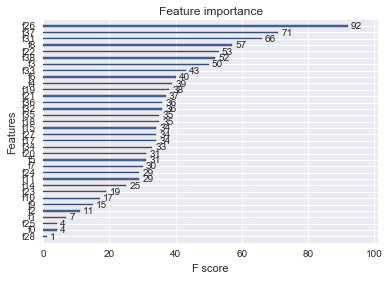

In [11]:
xgb.plot_importance(gbm)

In [10]:
# plot the top ten features

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]], yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Feature ranking:


NameError: name 'features' is not defined

In [ ]:
# Print the feature ranking
features2 = pd.DataFrame(features).iloc[indices[0:10]][0].values

print("Feature ranking (least important):")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[-f-1], features[indices[-f-1]], importances[indices[-f-1]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[-10:]], yerr=std[indices[-10:]], align="center")
plt.xticks(range(10), indices[-10:])
plt.xlim([-1, 10])
plt.show()

In [ ]:
tem = pd.concat([res[['correct']].iloc[range(0,22,2)], \
           log_res[['correct']].iloc[range(0,22,2)],\
           xgb_res[['correct']].iloc[range(0,22,2)] ], axis=1)

tem.columns = ['Random forest','Logistic regression','Gradient boosted']

tem